In [3]:
# 1. Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 2. Load dataset
df = pd.read_csv('spambase_csv.csv')
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


In [5]:
# 3. EDA
# Handle missing values
df = df.dropna(thresh=df.shape[1] * 0.5)
df = df.fillna(df.median(numeric_only=True))

In [6]:
# Handle outliers using IQR (numeric columns)
for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

In [7]:
# 4. Separate features and label
label_column = 'class'

In [8]:
# Encode categorical target if necessary
if df[label_column].dtype == 'object':
    le = LabelEncoder()
    df[label_column] = le.fit_transform(df[label_column])

In [9]:
features = df.drop(label_column, axis=1)
labels = df[label_column]

In [10]:
# One-hot encode categorical features
features = pd.get_dummies(features, drop_first=True)

In [11]:
# Feature scaling
scaler = StandardScaler()  # or MinMaxScaler(), Normalizer()
features_scaled = scaler.fit_transform(features)

In [12]:
# Data splitting
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## MODEL - Support Vector Machine

## Linear Kernel

In [13]:
from sklearn.svm import SVC
import time
start_time = time.time()
model = SVC(kernel='linear')
model.fit(X_train, y_train)
end_time = time.time()
training_linear_time = end_time - start_time
print(f"Training time: {end_time - start_time} seconds")

Training time: 0.350571870803833 seconds


In [14]:
# Cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_temp, y_temp, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores)
print("Mean CV Accuracy:", scores.mean())

param_dist = {
    'C': loguniform(1e-4, 1e3)   # from 0.0001 to 1000
}

# Randomized search
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=cv,
    random_state=42,
    n_jobs=-1
)

# Fit and update model
random_search.fit(X_temp, y_temp)
model = random_search.best_estimator_

# Results
print("Best C:", random_search.best_params_['C'])
print("Best CV Score:", random_search.best_score_)


Cross-Validation Accuracy Scores: [0.90252708 0.88405797 0.9057971  0.86594203 0.88043478]
Mean CV Accuracy: 0.8877517919740491
Best C: 0.10558813779064824
Best CV Score: 0.8906477266781773


Test Accuracy: 0.9015918958031838
[[382  23]
 [ 45 241]]
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       405
         1.0       0.91      0.84      0.88       286

    accuracy                           0.90       691
   macro avg       0.90      0.89      0.90       691
weighted avg       0.90      0.90      0.90       691



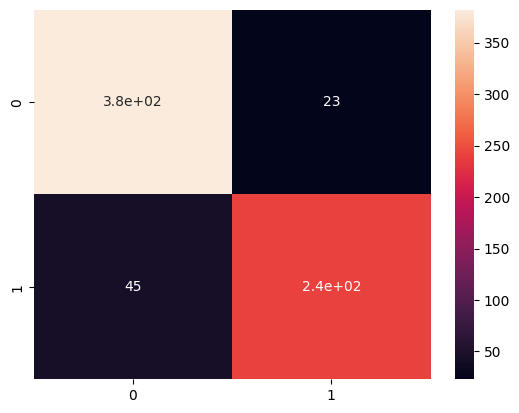

In [15]:
# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
accuracy_linear = accuracy_score(y_test, y_pred)
f1_linear = f1_score(y_test, y_pred)
print("Test Accuracy:", accuracy_linear)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

In [16]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(X_test_pca, columns=['PCA1', 'PCA2'])
plot_df['True Label'] = y_test.reset_index(drop=True)
plot_df['Predicted Label'] = y_pred

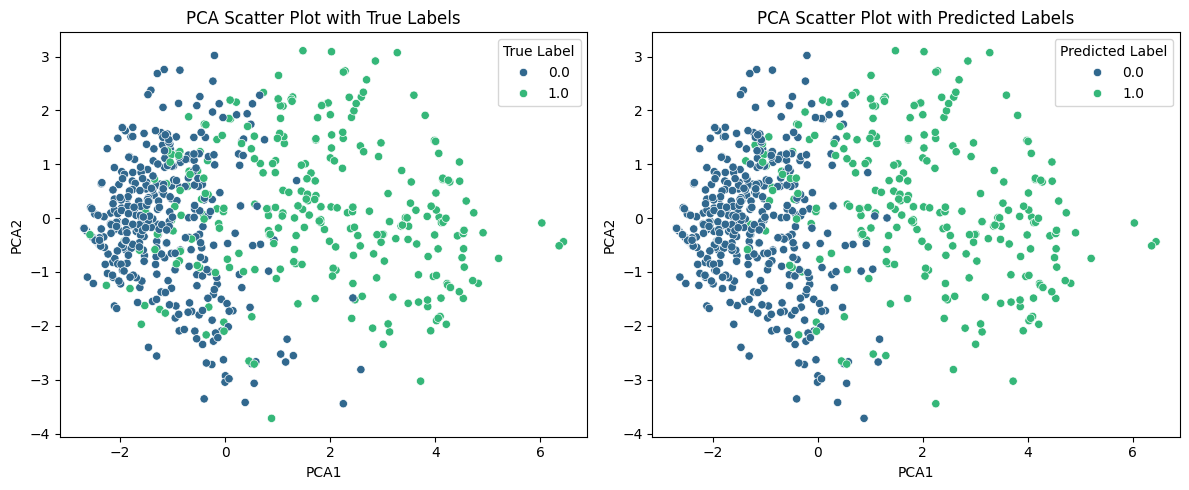

In [17]:
# Plot the scatter plot with true labels
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=plot_df, x='PCA1', y='PCA2', hue='True Label', palette='viridis')
plt.title('PCA Scatter Plot with True Labels')

# Plot the scatter plot with predicted labels
plt.subplot(1, 2, 2)
sns.scatterplot(data=plot_df, x='PCA1', y='PCA2', hue='Predicted Label', palette='viridis')
plt.title('PCA Scatter Plot with Predicted Labels')

plt.tight_layout()
plt.show()

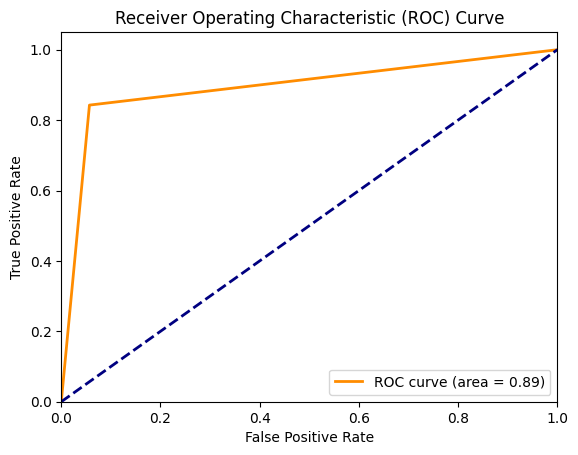

In [18]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Polynomial Kernel

In [28]:
from sklearn.svm import SVC
import time
start_time = time.time()
model_poly = SVC(kernel='poly')
model_poly.fit(X_train, y_train)
end_time = time.time()
training_poly_time = end_time - start_time
print(f"Training time: {end_time - start_time} seconds")

Training time: 0.40961241722106934 seconds


In [29]:
# Cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform, randint
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_poly = cross_val_score(model_poly, X_temp, y_temp, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores_poly)
print("Mean CV Accuracy:", scores_poly.mean())


param_dist = {
    'C': loguniform(1e-4, 1e3),
    'degree': randint(2, 7),
    'gamma': loguniform(1e-4, 1e1),
    'coef0': loguniform(1e-2, 1e2)
}

# Randomized search
random_search = RandomizedSearchCV(
    model_poly,
    param_distributions=param_dist,
    n_iter=30, # Reduced number of iterations
    scoring='accuracy',
    cv=cv,
    random_state=42,
    n_jobs=-1
)

# Fit and update model
random_search.fit(X_temp, y_temp)
model_poly = random_search.best_estimator_

# Results
print("Best parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

Cross-Validation Accuracy Scores: [0.90252708 0.87681159 0.86956522 0.85869565 0.88405797]
Mean CV Accuracy: 0.8783315021189766
Best parameters: {'C': np.float64(398.0842487361553), 'coef0': np.float64(2.485775286459208), 'degree': 4, 'gamma': np.float64(0.0006398916399944085)}
Best CV Score: 0.8986239732119501


Test Accuracy: 0.8958031837916064
[[392  13]
 [ 59 227]]
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       405
         1.0       0.95      0.79      0.86       286

    accuracy                           0.90       691
   macro avg       0.91      0.88      0.89       691
weighted avg       0.90      0.90      0.89       691



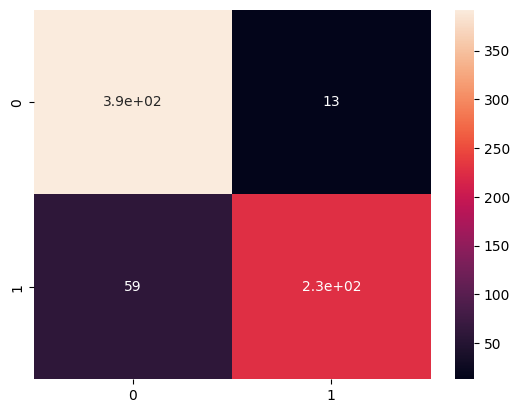

In [21]:
# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = model_poly.predict(X_test)
accuracy_poly = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy_poly)
f1_poly = f1_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

## RBF kernel

In [22]:
from sklearn.svm import SVC
start_time = time.time()
model_rbf = SVC(kernel='rbf')
model_rbf.fit(X_train, y_train)
end_time = time.time()
training_rbf_time = end_time - start_time
print(f"Training time: {end_time - start_time} seconds")

Training time: 0.2534763813018799 seconds


In [23]:
# Cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_rbf = cross_val_score(model_rbf, X_temp, y_temp, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores_rbf)
print("Mean CV Accuracy:", scores_rbf.mean())

# compute hyperparameter c and gamma
param_grid = {'C': [0.0001,0.001,0.01,0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(model_rbf, param_grid, cv=5)
grid_search.fit(X_temp, y_temp)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Cross-Validation Accuracy Scores: [0.89891697 0.89130435 0.91666667 0.86956522 0.89130435]
Mean CV Accuracy: 0.893551509443834
Best parameters: {'C': 1, 'gamma': 0.1}
Best cross-validation score: 0.9022497776382566


Test Accuracy: 0.8958031837916064
[[390  15]
 [ 44 242]]
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       405
         1.0       0.94      0.85      0.89       286

    accuracy                           0.91       691
   macro avg       0.92      0.90      0.91       691
weighted avg       0.92      0.91      0.91       691



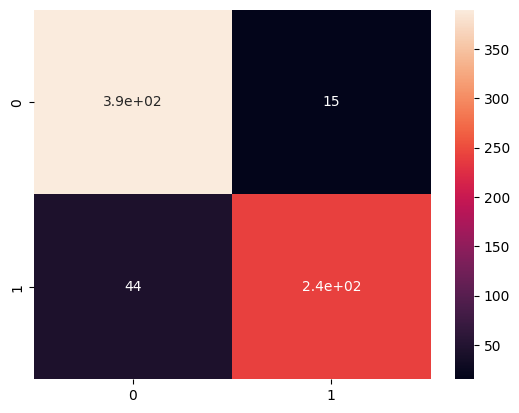

In [24]:
# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = model_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy_poly)
f1_rbf = f1_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

## Sigmoid Kernel

In [25]:
start_time = time.time()
model_sigmoid = SVC(kernel='sigmoid')
model_sigmoid.fit(X_train, y_train)
end_time = time.time()
training_sigmoid_time = end_time - start_time
print(f"Training time: {end_time - start_time} seconds")

Training time: 0.22423648834228516 seconds


In [26]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_sigmoid = cross_val_score(model_sigmoid, X_temp, y_temp, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores_sigmoid)
print("Mean CV Accuracy:", scores_sigmoid.mean())

# Automatic hyperparameter distribution
param_dist = {
    'C': loguniform(1e-3, 1e3),
    'gamma': loguniform(1e-4, 1e1),
    'coef0': loguniform(1e-2, 1e2)
}

# Randomized search
random_search = RandomizedSearchCV(
    model_sigmoid,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=cv,
    random_state=42,
    n_jobs=-1
)

# Fit and get best model
random_search.fit(X_temp, y_temp)
model_sigmoid = random_search.best_estimator_

# Print the best parameters and score
print("Best parameters (sigmoid):", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)
print("Best C:", random_search.best_params_['C'])
print("Best gamma:", random_search.best_params_['gamma'])
print("Best coef0:", random_search.best_params_['coef0'])

Cross-Validation Accuracy Scores: [0.86642599 0.85144928 0.84782609 0.80797101 0.85144928]
Mean CV Accuracy: 0.8450243289907394
Best parameters (sigmoid): {'C': np.float64(98.77700294007911), 'coef0': np.float64(0.07068974950624607), 'gamma': np.float64(0.0008111941985431928)}
Best CV accuracy: 0.8913697483388269
Best C: 98.77700294007911
Best gamma: 0.0008111941985431928
Best coef0: 0.07068974950624607


Test Accuracy: 0.8958031837916064
[[381  24]
 [ 45 241]]
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       405
         1.0       0.91      0.84      0.87       286

    accuracy                           0.90       691
   macro avg       0.90      0.89      0.90       691
weighted avg       0.90      0.90      0.90       691



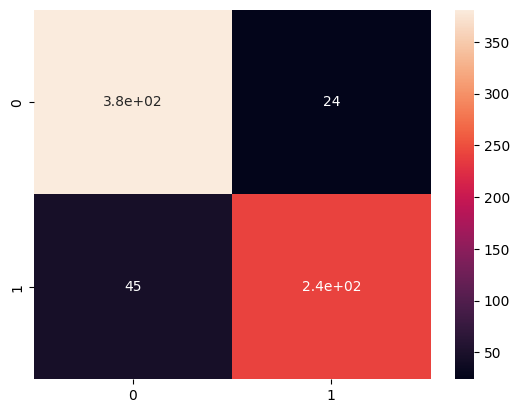

In [27]:
# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = model_sigmoid.predict(X_test)
accuracy_sigmoid = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy_poly)
f1_sigmoid = f1_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

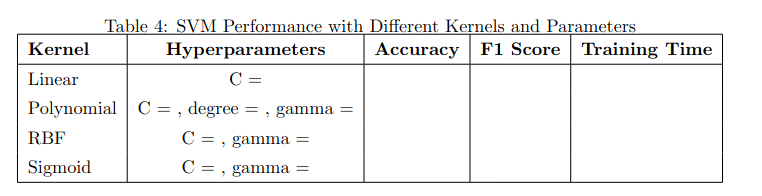

In [40]:
svm_performance = {
    "kernel": ["linear", "polynomial", "rbf", "Sigmoid"],
    "Hyperparameters": [{"C": 0.10558813779064824},{'C': 398.0842487361553 ,'gamma': 4 , 'degree': 0.0006398916399944085 },{'C': 1, 'gamma': 0.1},{'C': 98.77700294007911, 'gamma': 0.0008111941985431928} ],
    "Accuracy": [accuracy_linear, accuracy_poly, accuracy_rbf, accuracy_sigmoid],
    "F1 Score": [f1_linear, f1_poly, f1_rbf, f1_sigmoid],
    "Training Time(s)":[training_linear_time, training_poly_time ,training_rbf_time, training_sigmoid_time]
}


In [42]:
performance_df = pd.DataFrame(svm_performance)
performance_df.set_index("kernel", inplace=True)
print(performance_df)

                                              Hyperparameters  Accuracy  \
kernel                                                                    
linear                             {'C': 0.10558813779064824}  0.901592   
polynomial  {'C': 398.0842487361553, 'gamma': 4, 'degree':...  0.895803   
rbf                                    {'C': 1, 'gamma': 0.1}  0.914616   
Sigmoid     {'C': 98.77700294007911, 'gamma': 0.0008111941...  0.900145   

            F1 Score  Training Time(s)  
kernel                                  
linear      0.876364          0.350572  
polynomial  0.863118          0.409612  
rbf         0.891344          0.253476  
Sigmoid     0.874773          0.224236  
